In [1]:
!python --version

Python 3.8.17


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.13.0
Num GPUs Available:  1


In [2]:
# import du dataset
import pandas as pd
import seaborn as sns
import numpy as np
df = pd.read_csv('../dataset/edible_mushrooms.csv')

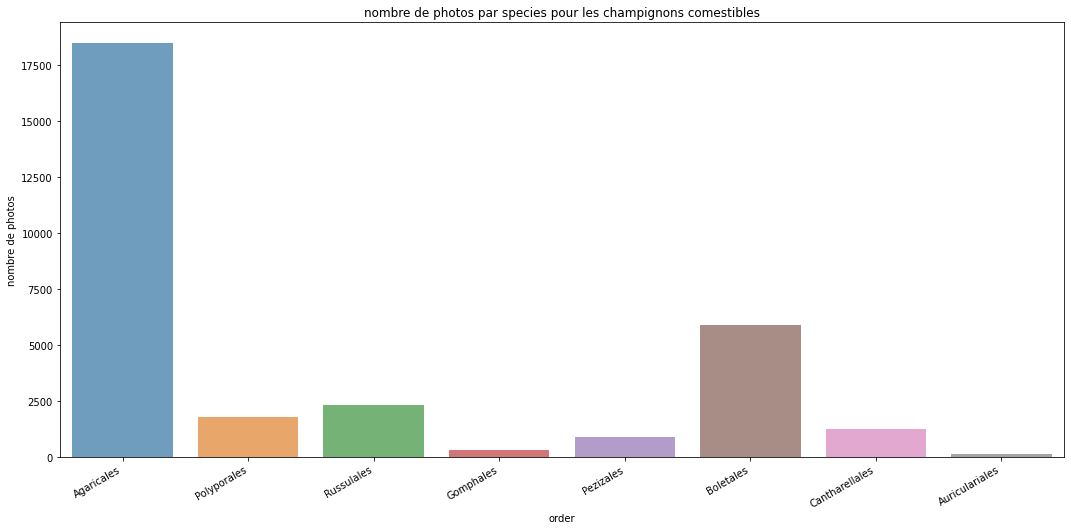

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 8))
ax = sns.countplot(data = df, x = 'order', alpha = 0.7)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_xlabel('order')
ax.set_ylabel('nombre de photos')
ax.set_title('nombre de photos par species pour les champignons comestibles');

# Balacing data

In [70]:
# sous échantillonnage de 'df_species_uncom'
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# Create the RandomUnderSampler object
undersample = RandomUnderSampler(sampling_strategy = 'auto')

# Undersample the dataframe
X = df.drop(columns = 'order')
y = df['order']
X_under, y_under = undersample.fit_resample(X, y)

In [71]:
y_under.value_counts()

Agaricales        136
Auriculariales    136
Boletales         136
Cantharellales    136
Gomphales         136
Pezizales         136
Polyporales       136
Russulales        136
Name: order, dtype: int64

# Generating data

In [73]:
path='../dataset/order'
train_path='../dataset/order/train'
test_path='../dataset/order/test'

In [74]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)

In [ ]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_path,
    class_mode = "sparse",
    target_size = (224,224), batch_size = 16)

In [ ]:
test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)

In [ ]:
test_generator = test_data_generator.flow_from_directory(
    directory = test_path,
    class_mode = "sparse",
    target_size = (224,224), batch_size = 16)

## balancing

In [79]:
from sklearn.utils import class_weight
import numpy as np

# Get the true labels from the generator
y_train = train_generator.classes

# Compute the class weights
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

# Create a dictionary mapping class indices to class weights
class_weight_dict = dict(enumerate(class_weights))


# VGG16 transfer learning

In [15]:

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
n_class= df['order'].unique().shape[0]

#base_model = MobileNet(weights = 'imagenet', include_top = False, input_shape=(224,224,3))
base_model = VGG16(weights = 'imagenet', include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

Num GPUs Available:  1


In [16]:
model.compile(optimizer='adam', 
               loss='sparse_categorical_crossentropy', 
               metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 15248200 (58.17 MB)
Trainable params: 533512 (2.04 MB)
Non-trainable params: 14714688 (56.13 MB)
___________

In [26]:
from tensorflow.keras.optimizers import Adam

# Train the model on the preprocessed images and labels from the dataframe
batch_size = 16

#tf.debugging.disable_traceback_filtering()

model_history = model.fit_generator(
    train_generator,
    epochs = 5,
    validation_data=test_generator
)

Epoch 1/5


<ipython-input-26-be0a147aaa82>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


1751/1751 [==============================] - 408s 232ms/step - loss: 1.0451 - acc: 0.6397 - val_loss: 0.9297 - val_acc: 0.6694
Epoch 2/5
1751/1751 [==============================] - 416s 237ms/step - loss: 0.9608 - acc: 0.6642 - val_loss: 1.1505 - val_acc: 0.5716
Epoch 3/5
1751/1751 [==============================] - 417s 238ms/step - loss: 0.9423 - acc: 0.6668 - val_loss: 0.9331 - val_acc: 0.6722
Epoch 4/5
1751/1751 [==============================] - 409s 233ms/step - loss: 0.9372 - acc: 0.6712 - val_loss: 0.9306 - val_acc: 0.6833
Epoch 5/5
1751/1751 [==============================] - 411s 235ms/step - loss: 0.9369 - acc: 0.6717 - val_loss: 0.9128 - val_acc: 0.6767


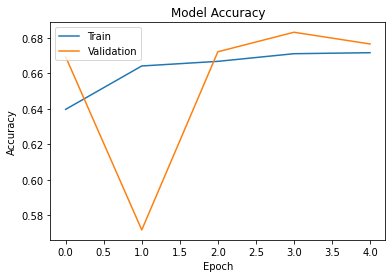

In [28]:
import matplotlib.pyplot as plt

# Assume `history` is the history object returned by the `fit` method
# Plot the accuracy and validation accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# transfer learning on Mobile Net

In [43]:
base_model = MobileNet(weights = 'imagenet', include_top = False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False
    
model_mobile = Sequential()
model_mobile.add(base_model)
model_mobile.add(GlobalAveragePooling2D()) 
model_mobile.add(Dense(1024,activation='relu'))
model_mobile.add(Dropout(rate=0.1))
model_mobile.add(Dense(n_class, activation='softmax'))

In [44]:
model_mobile.compile(optimizer='adam', 
               loss='sparse_categorical_crossentropy', 
               metrics=['acc'])
model_mobile.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 8)                 8200      
                                                                 
Total params: 4286664 (16.35 MB)
Trainable params: 105

In [45]:
from keras.callbacks import EarlyStopping

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model_mobile_history = model_mobile.fit_generator(
    train_generator,
    epochs = 10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


<ipython-input-45-663e973361f8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_history = model_mobile.fit_generator(


1751/1751 [==============================] - 109s 61ms/step - loss: 1.2048 - acc: 0.6797 - val_loss: 1.2183 - val_acc: 0.6259
Epoch 2/10
1751/1751 [==============================] - 111s 64ms/step - loss: 1.2348 - acc: 0.6966 - val_loss: 1.3649 - val_acc: 0.7174
Epoch 3/10
1751/1751 [==============================] - 108s 61ms/step - loss: 1.3067 - acc: 0.7035 - val_loss: 1.2222 - val_acc: 0.7328
Epoch 4/10
1751/1751 [==============================] - 109s 63ms/step - loss: 1.3960 - acc: 0.7043 - val_loss: 1.7750 - val_acc: 0.6978
Epoch 5/10
1751/1751 [==============================] - 111s 63ms/step - loss: 1.3719 - acc: 0.7131 - val_loss: 1.4183 - val_acc: 0.7379
Epoch 6/10
1751/1751 [==============================] - 110s 63ms/step - loss: 1.3719 - acc: 0.7174 - val_loss: 1.3662 - val_acc: 0.7338
Epoch 7/10
1751/1751 [==============================] - 110s 63ms/step - loss: 1.4760 - acc: 0.7142 - val_loss: 1.4829 - val_acc: 0.7117
Epoch 8/10
1751/1751 [==============================

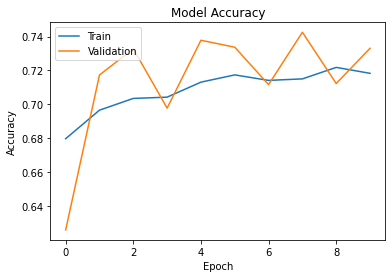

In [47]:
import matplotlib.pyplot as plt

# Assume `history` is the history object returned by the `fit` method
# Plot the accuracy and validation accuracy
plt.plot(model_mobile_history.history['acc'])
plt.plot(model_mobile_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [81]:
from sklearn.metrics import confusion_matrix

y_pred_proba = model_mobile.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
sns.heatmap(cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

199/199 [==============================] - 13s 55ms/step


In [60]:
# we can observe the tendency to classify any mushroom as part of the dominant class, a consequence of imbalancing

## on the balanced dataset

In [86]:
from keras.callbacks import EarlyStopping

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Fit the model using the class weights
model_mobile_balanced_history = model_mobile.fit_generator(
    train_generator,
    class_weight=class_weight_dict,
    epochs = 10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


<ipython-input-86-b489d70c2ff7>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_balanced_history = model_mobile.fit_generator(


1751/1751 [==============================] - 109s 62ms/step - loss: 5.6005 - acc: 0.5332 - val_loss: 4.0936 - val_acc: 0.5315
Epoch 2/10
1751/1751 [==============================] - 107s 61ms/step - loss: 3.8799 - acc: 0.5758 - val_loss: 3.9130 - val_acc: 0.6549
Epoch 3/10
1751/1751 [==============================] - 108s 62ms/step - loss: 3.4623 - acc: 0.5881 - val_loss: 3.7603 - val_acc: 0.6148
Epoch 4/10
1751/1751 [==============================] - 107s 61ms/step - loss: 4.0170 - acc: 0.5791 - val_loss: 4.3624 - val_acc: 0.5388
Epoch 5/10
1751/1751 [==============================] - 109s 62ms/step - loss: 4.0586 - acc: 0.5722 - val_loss: 7.2796 - val_acc: 0.4091


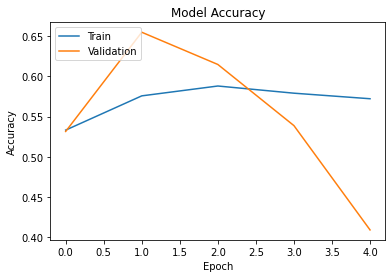

In [87]:
import matplotlib.pyplot as plt

# Assume `history` is the history object returned by the `fit` method
# Plot the accuracy and validation accuracy
plt.plot(model_mobile_balanced_history.history['acc'])
plt.plot(model_mobile_balanced_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix

y_pred_proba = model_mobile.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
sns.heatmap(cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Background removal

In [110]:
import imageio

# Read the image into a NumPy array
image = imageio.v3.imread('../dataset/images/0/18.jpg')

In [111]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="../sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [112]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(image, detections)

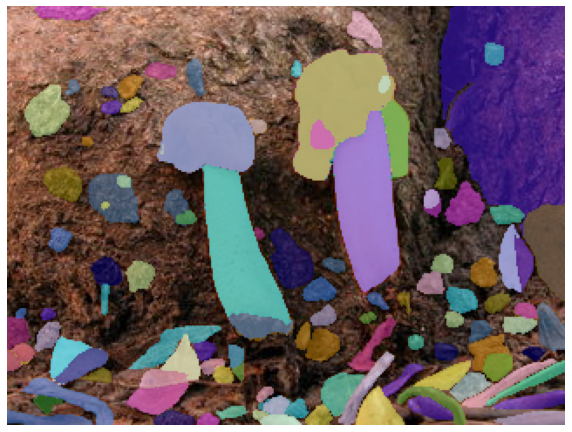

In [116]:
plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(annotated_image)


# Remove the axis
plt.axis('off')

# Show the plot
plt.show()

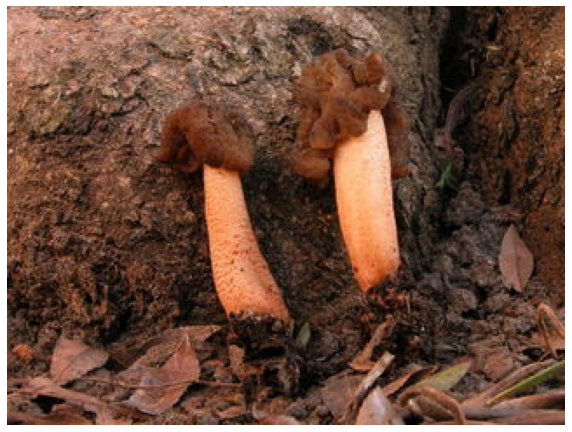

In [115]:
plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(image)


# Remove the axis
plt.axis('off')

# Show the plot
plt.show()

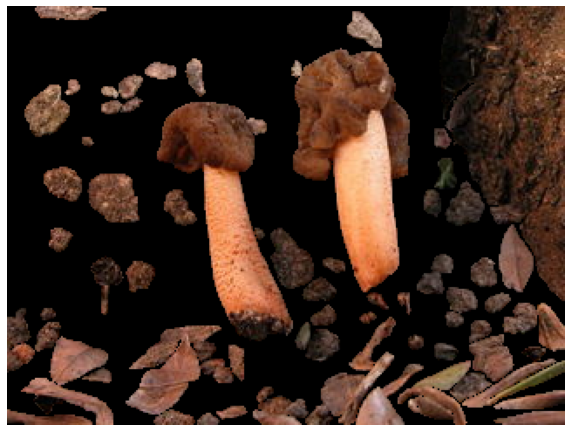

In [134]:
# derive background mask
background_mask = np.logical_not(np.logical_or.reduce(detections.mask))

# Apply the mask to the image
masked_image = np.where(background_mask[..., None], 0, image)

# Display image af
plt.figure(figsize=(10, 10))
plt.imshow(masked_image)

plt.axis('off')
plt.show()